In [ ]:
# Transform csv to pkl file
import pandas as pd
import os

csv_train = pd.read_csv("../input/sdf-dsi-2022/train.csv")
csv_test = pd.read_csv("../input/sdf-dsi-2022/test.csv")

csv_train.to_pickle("/".join((os.getcwd(), "train.pkl")))
csv_test.to_pickle("/".join((os.getcwd(), "test.pkl")))

## Load Dataset

In [ ]:
!pip install dabl
import dabl

In [2]:
import pandas as pd
import numpy as np
import pickle
import os

# train_raw = pd.read_pickle("/".join((os.getcwd(), "train.pkl")))
# test_raw = pd.read_pickle("/".join((os.getcwd(), "test.pkl")))
with open("/".join((os.getcwd(), "train.pkl")), 'rb') as f:
    train_raw = pickle.load(f)

with open("/".join((os.getcwd(), "test.pkl")), 'rb') as f:
    test_raw = pickle.load(f)    
    
train = train_raw.drop(columns=["transaction_id", 
                            "memo", 
                            "fee_account",  
                            "account",
                            "memo_type",
                            "prior_closed_at",
                            "time_bounds",
                            "current_ledger_sequence",
                            "prior_ledger_sequence",
                            "operation_types",
                            "surge_price_ind"])
# train = train.fillna(0)
train_label = train.fee_charged
train_data = train.drop(columns="fee_charged")

preprocessor = dabl.EasyPreprocessor()
train_data = dabl.clean(train_data)
preprocessor.fit(train_data)
train_data = preprocessor(train_data)


test = test_raw.drop(columns=["transaction_id", 
                          "prior_ledger_sequence",
                          "prior_closed_at",
                          "time_bounds",
                          "fee_account",
                          "operation_types",
                          "memo",
                          "memo_type",
                          "account"])
# test = test.fillna(0)

test = dabl.clean(test)
preprocessor.fit(test)
test = preprocessor(test)

attributes_train = train_data.columns
attributes_test = test.columns

if not sorted(attributes_train) == sorted(attributes_test):
    print(sorted(attributes_train))
    print(sorted(attributes_test))
    assert Exception("attributes do not match!")

train_data.head()

,prior_successful_transaction_count,prior_failed_transaction_count,prior_operation_count,prior_successful_operation_count,prior_max_fee_charged,prior_min_fee_charged,prior_avg_fee_charged,transaction_operation_count,max_fee_bid,new_max_fee_bid
0,381,173,960,770,10000,100,173.285199,1,110,0.0
1,174,338,950,601,10000,100,185.546875,1,110,0.0
2,205,319,988,626,10000,100,188.549618,1,110,0.0
3,244,207,921,690,10000,100,204.212860,1,110,0.0
4,196,197,914,709,10000,100,232.569975,1,110,0.0


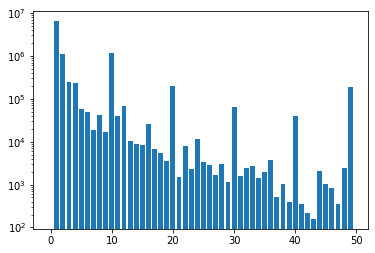

In [3]:
import matplotlib.pyplot as plt
from collections import defaultdict

train_label_data = train_label.to_numpy()
# I am going to give 50 bins
bins = np.zeros((50, ))
cnts = defaultdict(list)
for i, data in enumerate(train_label_data):
    index = min(49, data // 100)
    bins[index] += 1
    cnts[index].append(i)
plt.bar(range(len(bins)), bins)
plt.yscale("log")
plt.show()

In [4]:
downsample_limit = int(np.median(bins[1:-1]))
print(downsample_limit)

3677


## Build network

In [5]:
!pip install pytorch-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 171.2 kB/s eta 0:00:0000:0100:01


In [23]:
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
import torch.nn as nn
import copy

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def pretrain(pretrained_data, downsample=False):
    if downsample:
        indices = list()
        for key in cnts:
            sample_indices = np.random.choice(cnts[key], size=downsample_limit)
            indices.extend(sample_indices.tolist())
        indices = np.asarray(indices)
        pretrained_data = pretrained_data[indices]
    unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type="entmax",
    verbose=0)
    indices = int(len(pretrained_data) * 0.8)
    unsupervised_model.fit(X_train=pretrained_data[:indices],
                          eval_set=[pretrained_data[indices:]],
                          pretraining_ratio=0.8,
                          num_workers=1)
    print("pretrain completed!")
    return unsupervised_model

def train(batched_train_data, 
          batched_train_label, 
          batched_eval_data,
          batched_eval_label,
          continue_training=False,
          unsupervised_model=None,
          base_model=None):
    if len(batched_train_label.shape) == 1:
        batched_train_label = batched_train_label.reshape(-1, 1)
    if len(batched_val_label.shape) == 1:
        batched_eval_label = batched_eval_label.reshape(-1, 1)
    if continue_training:
        if base_model is None:
            assert Exception("Invalid checkpoint!")
        base_model.fit(X_train=batched_train_data,
           y_train=batched_train_label,
           eval_set=[(batched_eval_data, batched_eval_label)],
           eval_name=["valid"],
           eval_metric=["rmse"],
           from_unsupervised=unsupervised_model,
           augmentations=None)
        reg = copy.deepcopy(base_model)
    else:
        reg = TabNetRegressor(
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-3),
        scheduler_params={"step_size": 10,
                         "gamma": 0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type="entmax",
        verbose=0)
        reg.fit(X_train=batched_train_data,
               y_train=batched_train_label,
               eval_set=[(batched_eval_data, batched_eval_label)],
               eval_name=["valid"],
               eval_metric=["rmse"],
               from_unsupervised=unsupervised_model,
               augmentations=None)
    return reg


## Reconstruct dataset and train

In [ ]:
import copy
import warnings
warnings.filterwarnings("ignore")

unsupervised_model = pretrain(train_data.to_numpy(), True)
base_model = None
model_set = set()
ids = sorted(np.unique(train_raw.current_ledger_sequence.values))
merged_num_batches = len(ids) // 5
for i, trans_id in enumerate(ids):
    if i == 0 or i == len(ids)-1:
        continue
    if i % merged_num_batches and i != 1:
        continue_training = True
    else:
        continue_training = False
        if base_model is not None:
            model_set.add(copy.deepcopy(base_model))
        base_model = None
    prev_batched_data = train_data[train_raw.current_ledger_sequence == trans_id-1]
    prev_batched_label = train_label[train_raw.current_ledger_sequence == trans_id-1].to_numpy()
    batched_data = train_data[train_raw.current_ledger_sequence == trans_id]
    info_prev_batched_data = prev_batched_data.loc[:, ["max_fee_bid", 
                                                       "new_max_fee_bid", 
                                                       "transaction_operation_count"]]
    info_prev_batched_data = info_prev_batched_data.reset_index().drop(columns="index")
    info_batched_data = batched_data.loc[:, ["prior_successful_transaction_count", 
                                             "prior_failed_transaction_count", 
                                             "prior_operation_count", 
                                             "prior_successful_operation_count", 
                                             "prior_max_fee_charged", 
                                             "prior_min_fee_charged",
                                             "prior_avg_fee_charged"]]
    np_info_batched_data = np.tile(info_batched_data.to_numpy()[0], (len(prev_batched_label), 1))
    info_batched_data = pd.DataFrame(np_info_batched_data, columns=["prior_successful_transaction_count", 
                                             "prior_failed_transaction_count", 
                                             "prior_operation_count", 
                                             "prior_successful_operation_count", 
                                             "prior_max_fee_charged", 
                                             "prior_min_fee_charged",
                                             "prior_avg_fee_charged"])
    info_batched_data = info_batched_data.reset_index().drop(columns="index")
    final_batched_data = pd.concat((info_prev_batched_data, info_batched_data), axis=1).to_numpy()
    indices = int(len(final_batched_data) * 0.8)
    batched_train_data = final_batched_data[:indices]
    batched_train_label = prev_batched_label[:indices]
    batched_val_data = final_batched_data[indices:]
    batched_val_label = prev_batched_label[indices:]
    base_model = train(batched_train_data, 
                      batched_train_label, 
                      batched_val_data, 
                      batched_val_label, 
                      continue_training,
                      unsupervised_model,
                      base_model=base_model)

In [ ]:
results = np.zeros((len(model_set), len(test)))
# preprocssing test set
ids = sorted(np.unique(test_raw.prior_ledger_sequence.values))
for trans_id in ids:
    indices = test_raw.prior_ledger_sequence == trans_id
    if trans_id == max(ids):
        final_batched_data = test[indices].to_numpy()
        for i, model in enumerate(model_set):
            results[i, indices] = model.predict(final_batched_data)
    else:
        prev_batched_data = test[test_raw.prior_ledger_sequence == trans_id]
        batched_data = test[train_raw.prior_ledger_sequence == trans_id+1]
        info_prev_batched_data = prev_batched_data.loc[:, ["max_fee_bid", 
                                                           "new_max_fee_bid", 
                                                           "transaction_operation_count"]]
        info_prev_batched_data = info_prev_batched_data.reset_index()
        info_batched_data = batched_data.loc[:, ["prior_successful_transaction_count", 
                                                 "prior_failed_transaction_count", 
                                                 "prior_operation_count", 
                                                 "prior_successful_operation_count", 
                                                 "prior_max_fee_charged", 
                                                 "prior_min_fee_charged",
                                                 "prior_avg_fee_charged"]]
        info_batched_data = info_batched_data.reset_index()
        final_batched_data = pd.concat((info_prev_batched_data, info_batched_data), axis=1)
        for i, model in enumerate(model_set):
            results[i, indices] = model.predict(final_batched_data.to_numpy())
predict = results.mean(0)
predict = np.where(predict < 100, 100, predict)

## Submit final prediction

In [30]:
sample_submit = pd.read_csv("/".join(("../input/sdf-dsi-2022", "sample_submission.csv")))
sample_submit.predicted_fee = predict
sample_submit.to_csv("./submission.csv", index=None)